# SSM non parametrique 

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dropout,PReLU, LSTM, Reshape, Dense
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant

from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

## Layer Personnalisé

In [4]:

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self,X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Test de Base

In [8]:

# Generate some random data for testing

scaler = MinMaxScaler()
dff = pd.read_csv(r"../data/Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=10, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
    batch_size=64)


# Optionally, you can save the model for later use
model.save('../models/rbf_model.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

Epoch 1/100
3582/3582 [==============================] - 10s 3ms/step - loss: 11589.2393 - val_loss: 985.9949
Epoch 2/100
3582/3582 [==============================] - 8s 2ms/step - loss: 127.7233 - val_loss: 832.5777
Epoch 3/100
3582/3582 [==============================] - 8s 2ms/step - loss: 88.5572 - val_loss: 664.9536
Epoch 4/100
3582/3582 [==============================] - 7s 2ms/step - loss: 49.4129 - val_loss: 447.7820
Epoch 5/100
3582/3582 [==============================] - 7s 2ms/step - loss: 29.1009 - val_loss: 302.7109
Epoch 6/100
3582/3582 [==============================] - 9s 3ms/step - loss: 24.2606 - val_loss: 235.3869
Epoch 7/100
3582/3582 [==============================] - 9s 3ms/step - loss: 21.9540 - val_loss: 197.2379
Epoch 8/100
3582/3582 [==============================] - 9s 2ms/step - loss: 20.2343 - val_loss: 171.5845
Epoch 9/100
3582/3582 [==============================] - 8s 2ms/step - loss: 18.9353 - val_loss: 153.4826
Epoch 10/100
3582/3582 [=================

KeyboardInterrupt: 

## Tests

### Test 1 : Normaliser les données

In [ ]:

# Generate some random data for testing

scaler = MinMaxScaler()
dff = pd.read_csv(r"../data/Appl_data.csv",sep=";",decimal=',')[["Date","price"]]
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff = dff.dropna().drop(columns=['t'])

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=10, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=64)


# Optionally, you can save the model for later use
model.save('../models/rbf_model_1.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

### Test 2 - eviter l'overfitting

In [ ]:

# Generate some random data for testing

scaler = MinMaxScaler()
dff = pd.read_csv(r"../data/Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=10, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.3,
    batch_size=64,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('rbf_model_2.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

### Test 3 - augmenter le nombre de neurone par couches

In [ ]:

# Generate some random data for testing

scaler = MinMaxScaler()
dff = pd.read_csv(r"../data/Appl_data.csv",sep=";",decimal=',')[["Date","price"]]
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=100, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size=64)


# Optionally, you can save the model for later use
model.save('rbf_model.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

pour 100 neurones : 100 epoch - loss : 0.0123   -> TROP FIDELE
                                       0.0130
                    50 epoch  - loss : 0.0225   -> TROP FIDELE
                                       0.0176
                    10 epoch  - loss : 15.9658  -> PAS ASSEZ
                                       15.9249
                    20 epoch  - loss : 2.8253   -> PAS DINGUE
                                       3.5893
                    30 epoch  - loss : 0.0331   -> TROP FIDELE
                                       0.0389
                    25 epoch  - loss : 0.7080  -> BOF
                                       0.5523
                                
                                    
                    
                                       

## Test sur Valeur Apple

### Tick Data

Epoch 1/10
2188/2188 [==============================] - 10s 4ms/step - loss: 0.0381 - val_loss: 0.0044
Epoch 2/10
2188/2188 [==============================] - 8s 4ms/step - loss: 3.0757e-04 - val_loss: 0.0015
Epoch 3/10
2188/2188 [==============================] - 8s 4ms/step - loss: 1.8338e-04 - val_loss: 6.4052e-04
Epoch 4/10
2188/2188 [==============================] - 8s 4ms/step - loss: 1.3527e-04 - val_loss: 4.9624e-04
Epoch 5/10
2188/2188 [==============================] - 8s 3ms/step - loss: 1.0678e-04 - val_loss: 5.0524e-04
Epoch 6/10
2188/2188 [==============================] - 8s 4ms/step - loss: 9.7568e-05 - val_loss: 3.5727e-04
Epoch 7/10
2188/2188 [==============================] - 7s 3ms/step - loss: 9.0908e-05 - val_loss: 2.6971e-04
Epoch 8/10
2188/2188 [==============================] - 6s 3ms/step - loss: 9.0372e-05 - val_loss: 2.4785e-04
Epoch 9/10
2188/2188 [==============================] - 7s 3ms/step - loss: 8.9861e-05 - val_loss: 2.4156e-04
Epoch 10/10
   1/3125

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3125/3125 [==============================] - 6s 2ms/step


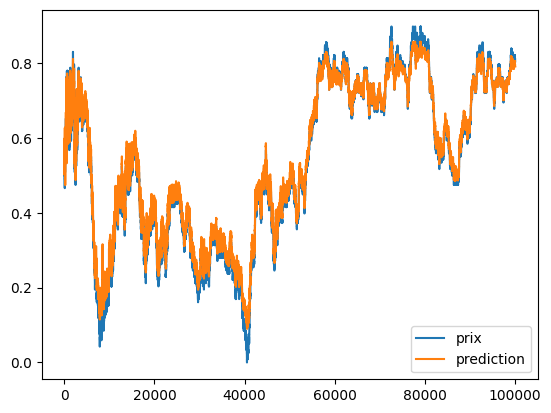

In [288]:
# Generate some random data for testing
from tensorflow.keras import regularizers


scaler = MinMaxScaler()
dff = pd.read_csv(r"../data/Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff['mean'] = dff.returns.rolling(30).mean()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)
scaler = MinMaxScaler()

# Appliquez la normalisation
df = scaler.fit_transform(dff)
df = pd.DataFrame(df, columns=dff.columns)


x_train = df.to_numpy()[:100000]
y_train = df.prices.to_numpy().reshape(-1,1)[1:100001]
x_test = df.to_numpy()[100000:-1]
y_test = df.prices.to_numpy().reshape(-1,1)[100001:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build the model
model = Sequential()
model.add(RBFLayer(output_dim=16, initializer=rbf_initializer, betas=1.0, input_shape=(5,)))
model.add(Reshape((1, 16)))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.3,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('rbf_model_test.h5')
pred = model.predict(x_train)
plt.plot(y_train, label='prix')
plt.plot(pred, label='prediction')

# Afficher la légende
plt.legend()




On teste sur le modèle sur mes données tests

5828/5828 [==============================] - 10s 2ms/step


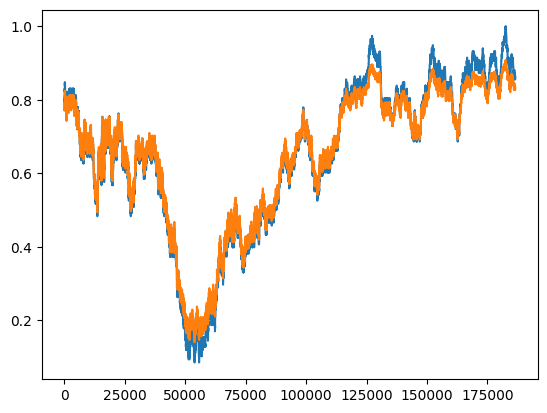

In [289]:
pred = model.predict(x_test)
plt.plot(y_test, label='prix')
plt.plot(pred, label='prediction')

In [290]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, pred)
mse

0.0006475136502948994

Il fit super bien <br>
avec LSTM : 0.0008157658068240495 <br>
sans LSTM : 0.0006475136502948994

### Tick data mais plus grand dataframe

Epoch 1/10
10938/10938 [==============================] - 54s 5ms/step - loss: 0.0067 - val_loss: 2.5293e-06
Epoch 2/10
10938/10938 [==============================] - 53s 5ms/step - loss: 7.3832e-08 - val_loss: 2.1329e-06
Epoch 3/10
10938/10938 [==============================] - 52s 5ms/step - loss: 1.0862e-07 - val_loss: 2.1303e-06
Epoch 4/10
10938/10938 [==============================] - 53s 5ms/step - loss: 1.0882e-07 - val_loss: 2.1230e-06
Epoch 5/10
10938/10938 [==============================] - 49s 4ms/step - loss: 1.0913e-07 - val_loss: 2.1268e-06
Epoch 6/10
10938/10938 [==============================] - 48s 4ms/step - loss: 1.0954e-07 - val_loss: 2.1261e-06
Epoch 7/10
10938/10938 [==============================] - 50s 5ms/step - loss: 1.1002e-07 - val_loss: 2.1256e-06
Epoch 8/10
10938/10938 [==============================] - 49s 4ms/step - loss: 1.1043e-07 - val_loss: 2.1326e-06
Epoch 9/10
10938/10938 [==============================] - 48s 4ms/step - loss: 1.1102e-07 - val_loss

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15625/15625 [==============================] - 38s 2ms/step


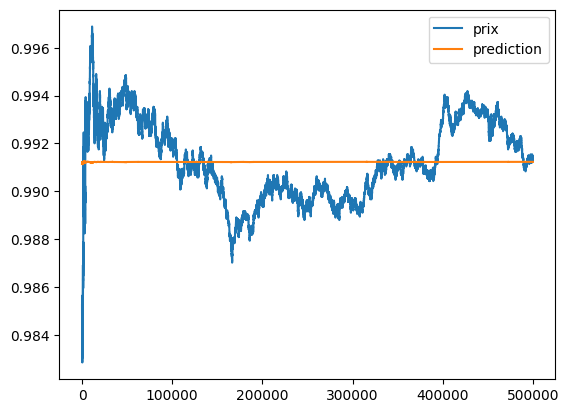

In [322]:
dff = pd.read_csv(r"C:\Users\collo\Forecasting-high-low-with-Kalman-filters\Data_apple_ibm.csv",sep=";",decimal=',',header=None) #sheet_name="Feuil3"
dff.columns=columns=['Date','Ask','Price','Tick']
dff = dff[["Date","Price"]]
dff.rename(columns={"Date": "t", "Price": "prices"},inplace=True)
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff['mean'] = dff.returns.rolling(30).mean()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)
scaler = MinMaxScaler()
# Appliquez la normalisation
df = scaler.fit_transform(dff)
df = pd.DataFrame(df, columns=dff.columns)



x_train = df.to_numpy()[:500000]
y_train = df.prices.to_numpy().reshape(-1,1)[1:500001]

x_test1 = df.to_numpy()[500000:700000]
y_test1 = df.prices.to_numpy().reshape(-1,1)[500001:700001]

x_test2 = df.to_numpy()[700000:-1]
y_test2 = df.prices.to_numpy().reshape(-1,1)[700001:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build the model
model1= Sequential()
model1.add(RBFLayer(output_dim=4, initializer=rbf_initializer, betas=1.0, input_shape=(5,)))
model1.add(Reshape((1, 4)))
model1.add(LSTM(units=2, activation='relu'))
model1.add(Dense(1))


# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model1.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.3,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model1.save('../models/rbf_model_test1.h5')
pred = model1.predict(x_train)
plt.plot(y_train, label='prix')
plt.plot(pred, label='prediction')

# Afficher la légende
plt.legend()

On teste sur les données de tests

6250/6250 [==============================] - 16s 3ms/step


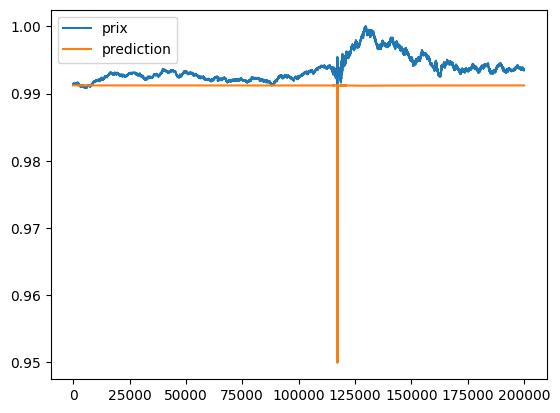

In [323]:
# Optionally, you can save the model for later use
pred = model1.predict(x_test1)
y_test1= pd.DataFrame(y_test1)
y_test1.loc[y_test1[0]<0.95,0]=0.95
pred= pd.DataFrame(pred)
pred.loc[pred[0]<0.95,0]=0.95
plt.plot(y_test1, label='prix')
plt.plot(pred, label='prediction')
plt.legend()

In [325]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test1, pred)
mse

9.258924888161085e-06

avec LSTM : 1.531768160536565e-05 et 9.258924888161085e-06
sans LSTM : 1.618161726756153e-06


4458/4458 [==============================] - 11s 2ms/step


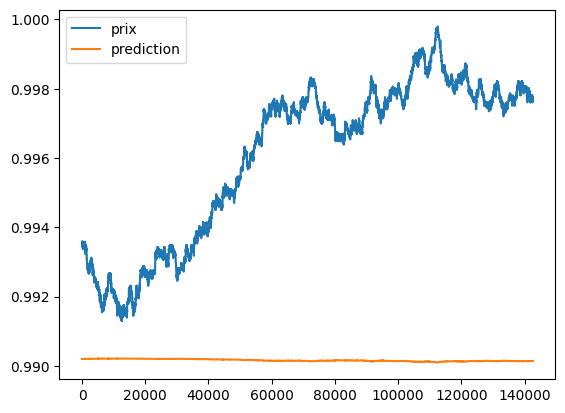

In [311]:
# Optionally, you can save the model for later use
model1.save('../models/rbf_model_test1.h5')
pred = model1.predict(x_test2)
plt.plot(y_test2, label='prix')
plt.plot(pred, label='prediction')
plt.legend()

Il fit bien aussi :)

### Apple Data par Minute

Epoch 1/20
147/147 [==============================] - 2s 6ms/step - loss: 0.0353 - val_loss: 0.0061
Epoch 2/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 3/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 4/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 5/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 6/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 8.4437e-04
Epoch 7/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 7.1025e-04
Epoch 8/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 6.2711e-04
Epoch 9/20
147/147 [==============================] - 1s 4ms/step - loss: 0.0010 - val_loss: 5.5008e-04
Epoch 10/20
147/147 [==============================] - 0s 3ms/step - loss: 8.2845e-0

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 0s 2ms/step


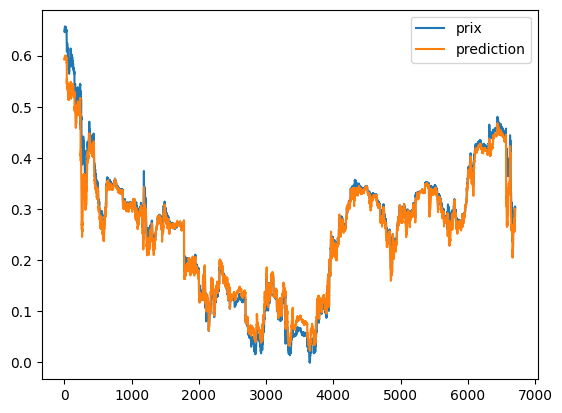

In [306]:
# Generate some random data for testing
from tensorflow.keras import regularizers


scaler = MinMaxScaler()
dff = pd.read_csv(r"..\data\Data_apple_ibm1.csv",sep=";",decimal=',',header=None) #sheet_name="Feuil3"
dff.columns=columns=['Date','Price']
dff = dff[["Date","Price"]]
dff.rename(columns={"Date": "t", "Price": "prices"},inplace=True)
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff['mean'] = dff.returns.rolling(30).mean()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)
scaler = MinMaxScaler()
# Appliquez la normalisation
df = scaler.fit_transform(dff)
df = pd.DataFrame(df, columns=dff.columns)


x_train = df.to_numpy()[:len(df)//2]
y_train = df.prices.to_numpy().reshape(-1,1)[1:len(df)//2+1]
x_test = df.to_numpy()[len(df)//2:-1]
y_test = df.prices.to_numpy().reshape(-1,1)[len(df)//2+1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build the model
model = Sequential()
model.add(RBFLayer(output_dim=64, initializer=rbf_initializer, betas=1.0, input_shape=(5,)))
model.add(Reshape((1, 64)))
model.add(LSTM(units=2, activation='relu'))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.3,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('../models/rbf_model_test.h5')
pred = model.predict(x_train)
plt.plot(y_train, label='prix')
plt.plot(pred, label='prediction')
plt.legend()




On évalue sur les données de tests

210/210 [==============================] - 0s 2ms/step


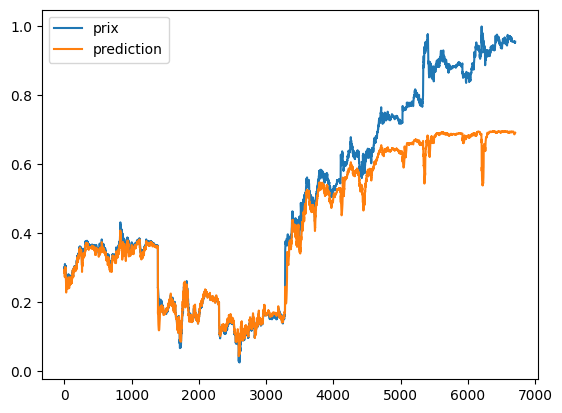

In [307]:
pred = model.predict(x_test)
plt.plot(y_test, label='prix')
plt.plot(pred, label='prediction')
plt.legend()


ça fit plutot bien

In [308]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, pred)
mse

0.013474086953950557

sans LSTM : 0.013474086953950557
avec LSTM : 0.009648587277246662